In [2]:
import tensorflow as tf

# Hide GPU from visible devices for tensorflow 2.3.1 and above
tf.config.set_visible_devices([], 'GPU')

import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras

from keras.utils import np_utils

from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2. Read images from the data path

In [3]:
#Define Datapath
data_path = 'CK+48/'
data_dir_list = os.listdir(data_path)

img_rows=256
img_cols=256
num_channel=1

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-anger

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy

Loaded the images of dataset-sadness

Loaded the images of dataset-surprise



(981, 48, 48, 3)

# 3. Define the number of classes

In [30]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=1 #54
labels[189:365]=2 #177
labels[366:440]=3 #75
labels[441:647]=4 #207
labels[648:731]=5 #84
labels[732:980]=6 #249

names = ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE']

def getLabel(id):
    return ['ANGRY','DISGUST','FEAR','HAPPY','NEUTRAL','SAD','SURPRISE'][id]

# 4.Convert the class label to one-hot encoding

In [31]:
# convert class labels to on-hot encoding# conve 
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=2)

# 5. CNN Layer Set

In [32]:
# Defining the model

input_shape=img_data[0].shape

model = tf.keras.Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding="same",input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


#2nd CNN layer
model.add(Conv2D(128,(5,5),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output layer
model.add(Dense(num_classes,activation="softmax"))

#Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=["accuracy"])

# 6.View Model Configuration

In [33]:
model.summary()
model.get_config()
model.layers[0].get_config()
model.layers[0].input_shape
model.layers[0].output_shape
model.layers[0].get_weights()
np.shape(model.layers[0].get_weights()[0])
model.layers[0].trainable

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_11 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_11 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)      

True

In [35]:
from keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
# filename='model_train_new.csv'
# filepath="Best-weights-my_model-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"

# csv_log=callbacks.CSVLogger(filename, separator=',', append=False)
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 13),
                ModelCheckpoint(
                    filepath='model.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]
# callbacks_list = [csv_log,checkpoint]
# callbacks_list = [csv_log]

# 7. Train Model

In [36]:
# Training
hist = model.fit(X_train, y_train, batch_size=7, epochs=200, verbose=1, validation_data=(X_test, y_test),callbacks=[checkpointer])

Epoch 1/200
119/119 [==============================] - ETA: 0s - loss: 1.8150 - accuracy: 0.3673
Epoch 1: val_accuracy improved from -inf to 0.06081, saving model to model.weights.best.hdf5
119/119 [==============================] - 17s 128ms/step - loss: 1.8150 - accuracy: 0.3673 - val_loss: 2.6509 - val_accuracy: 0.0608
Epoch 2/200
119/119 [==============================] - ETA: 0s - loss: 1.1733 - accuracy: 0.5906
Epoch 2: val_accuracy improved from 0.06081 to 0.07432, saving model to model.weights.best.hdf5
119/119 [==============================] - 17s 139ms/step - loss: 1.1733 - accuracy: 0.5906 - val_loss: 3.5094 - val_accuracy: 0.0743
Epoch 3/200
119/119 [==============================] - ETA: 0s - loss: 0.9062 - accuracy: 0.6687
Epoch 3: val_accuracy did not improve from 0.07432
119/119 [==============================] - 17s 142ms/step - loss: 0.9062 - accuracy: 0.6687 - val_loss: 3.9430 - val_accuracy: 0.0743
Epoch 4/200
119/119 [==============================] - ETA: 0s - lo

In [37]:
#Model Save
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

<Figure size 432x288 with 0 Axes>

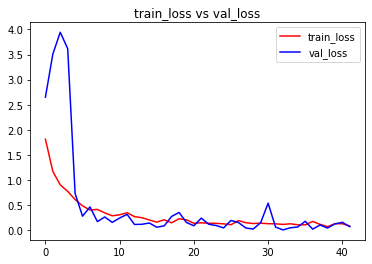

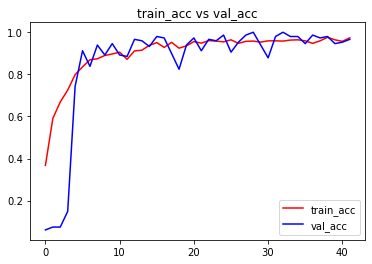

<Figure size 432x288 with 0 Axes>

In [38]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

Test Loss: 0.028065552935004234
Test accuracy: 1.0
(1, 48, 48, 3)
1/1 [==============================] - 0s 191ms/step
[[9.9766111e-01 2.2179782e-03 2.0520426e-07 1.0227721e-04 2.3694502e-06
  1.6018710e-05 9.2939372e-09]]
[0]
[[1. 0. 0. 0. 0. 0. 0.]]
1/1 [==============================] - 0s 68ms/step


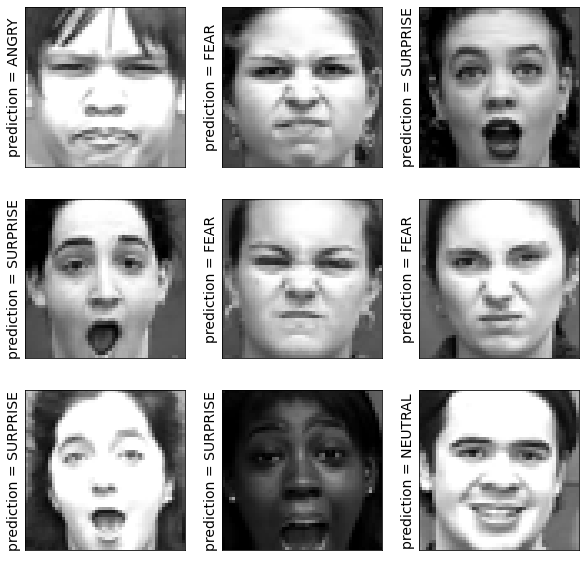

In [39]:
# Evaluating the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

predict_x=model.predict(test_image)
print(predict_x)
# print(model.predict_classes(test_image))
print(np.argmax(predict_x,axis=1))
print(y_test[0:1])

# res = model.predict_classes(X_test[:9])
res = np.argmax(model.predict(X_test[:9]), axis=1)
plt.figure(figsize=(10, 10))

for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_test[i],cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('prediction = %s' % getLabel(res[i]), fontsize=14)
# show the plot
plt.show()

5/5 [==============================] - 0s 87ms/step


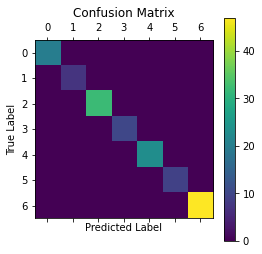

In [40]:
from sklearn.metrics import confusion_matrix
results = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(np.where(y_test == 1)[1], results)
plt.matshow(cm)
plt.title('Confusion Matrix')
plt.colorbar()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

test image original shape (48, 48, 3)
image original shaape (48, 48, 3)
1/1 [==============================] - 0s 37ms/step


Text(0.5, 0, 'prediction = HAPPY')

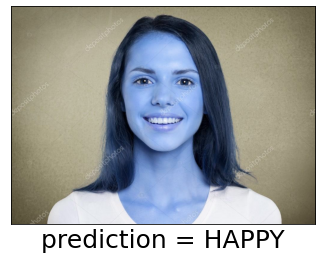

In [41]:
testimg_data_list=[]
test_img=cv2.imread('happy.jpg', 1)

test_img_resize=cv2.resize(test_img,(48,48))
testimg_data_list.append(test_img_resize)
testimg_data = np.array(testimg_data_list)
testimg_data = testimg_data.astype('float32')
testimg_data = testimg_data/255
testimg_data.shape

print("test image original shape",testimg_data[0].shape)
print("image original shaape",img_data[0].shape)

results = np.argmax(model.predict(testimg_data), axis=1)
plt.imshow(test_img,cmap=plt.get_cmap('Set2'))
plt.gca().get_xaxis().set_ticks([])
plt.gca().get_yaxis().set_ticks([])
plt.xlabel('prediction = %s' % getLabel(results[0]), fontsize=25)